# Multi-Input Shaping

### Forrest Montgomery

<img src="2_input.pdf" width="500" />

This notebook will outline how to form the Modal State-Space equations of motion for the above figure.

In [1]:
from sympy import symbols, init_printing
import sympy
import sympy.physics.mechanics as me
from pydy.system import System
from scipy.integrate import ode
import matplotlib as mpl
import matplotlib.pyplot as plt
import itable
import pandas as pd
import numpy as np
%matplotlib inline
init_printing(True)
import InputShaping as shaping
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
# Create the generalized coordinates and their derivatives
x1, x2, theta = me.dynamicsymbols('x_1 x_2 theta')
x1_dot, x2_dot, theta_dot = me.dynamicsymbols('x_1 x_2 theta', 1)

# Create the constants symbols
L, m1, m2, m3, t, g, k, c = sympy.symbols('L m_1 m_2 m_3 t g k c')

# Create the forces
f1, f2 = me.dynamicsymbols('f_1 f_2')

In [3]:
# Create the Main Frame
A = me.ReferenceFrame('A')

# Create a frame along the pendulum
B = A.orientnew('B', 'Axis', [theta, A.z])

# Define the large cart point and its velocity
T = me.Point('T')
T.set_vel(A, x1_dot * A.x)

# Define the large cart point as a particle
LC = me.Particle('LC', T, m1)

# Define the small cart point and its velocity
D = me.Point('D')
D.set_vel(A, (x1_dot + x2_dot) * A.x)

# Define the small cart point as a particle
SC = me.Particle('SC', D, m2)

# Define the pendulum point and its velocity
P = D.locatenew('P', -L * B.y)
P.set_vel(A, (x1_dot + x2_dot + (L * theta_dot))*A.x)

# Define the pendulum as a particle
Pa = me.Particle('Pa', P, m3)

In [4]:
# Set the potential energy
SC.potential_energy = 0.5 * k * x2**2
Pa.potential_energy = -m3 * g * L * sympy.cos(theta)

# Set the forces applied
forces = [(T, (f1-2*f2) * A.x), (D, (f2 * A.x))]

# Form the Lagrangian
Lag = me.Lagrangian(A, LC, SC, Pa)
LM = me.LagrangesMethod(Lag, [x1, x2, theta], forcelist = forces, frame = A)
# Lag.simplify()
LM.form_lagranges_equations()
# Make the call to set up in state-space-ish form q_dot = f(q, t)
lrhs = LM.rhs()

In [5]:
# Define the point to linearize around
op_point = {x1: 0.0,
            x1_dot: 0.0,
            x2: 0.0,
            x2_dot: 0.0,
            theta: 0.0,
            theta_dot: 0.0}

constants = {m1: 10,
             m2: 5,
             m3: 1,
             g: 9.81,
             L: 0.25,
             k: 3}

# Make the call to the linearizer
linearizer = LM.to_linearizer(q_ind=[x1,x2,theta], qd_ind=[x1_dot,x2_dot,theta_dot])
# Form the Mass, A and B matrices
Maz, A, B = linearizer.linearize()

# Sub in the constants and convert the matrices to numpy
M_op = me.msubs(Maz, op_point)
A_op = me.msubs(A, op_point)
B_op = me.msubs(B, op_point)
perm_mat = linearizer.perm_mat
A_lin = perm_mat.T * M_op.LUsolve(A_op)
B_lin = perm_mat.T * M_op.LUsolve(B_op)

A_lin_constants = me.msubs(A_lin, constants)
B_lin_constants = me.msubs(B_lin, constants)
A_sol = A_lin_constants.subs(op_point).doit()
B_sol = B_lin_constants.subs(op_point).doit()

A_np = np.array(np.array(A_sol), np.float)
B_np = np.array(np.array(B_sol), np.float)

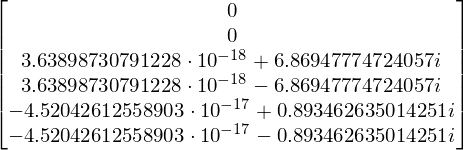

In [6]:
# Solve for the eigenvalues
eigenvals, eigenvects = np.linalg.eig(A_np)
sympy.Matrix(eigenvals)

The system has three poles, each with a multiplicty of 2. Notice one is zero, this is from the rigidbody mode.
$$0.0\pm0.0j$$
$$0.0\pm6.87j$$
$$0.0\pm0.89j$$
We can then take the absolute value of the poles to find the natural frequencies. In this case it will be the imaginary part.

Mechanical systems with k degrees of freedom undergoing small motions:

$$M\ddot{q}(t)+D\dot{q}(t)+Kq(t)=F(t)$$

Where:
* $M$ is the Mass Matrix
* $K$ is the Stiffness Matrix
* $D$ is the Damping Matrix

Let the state be $x(t)=\begin{bmatrix}q(t) \\ \dot{q(t)}\end{bmatrix}$

$$\dot{x}(t)=\begin{bmatrix}0 & I \\ -M^{-1}K & -M^{-1}D\end{bmatrix}x(t)+\begin{bmatrix}0\\M^{-1}\end{bmatrix}F(t)$$

Therefore to solve for the stiffness matrix, $K$, we only need the $-M^{-1}K$ submatrix.

So, $$K=-MA$$

In [7]:
# Extract only the submatrix
A_matrix = A_np[3:,:3]

# Solve for the eigenvalues and vectors
eigenvals, eigenvects = np.linalg.eig(A_matrix)

In [8]:
# Sort them and convert to numpy matrices
orth1 = np.asmatrix(eigenvects[:,0])
orth2 = np.asmatrix(eigenvects[:,1])
orth3 = np.asmatrix(eigenvects[:,2])

# Here I am converting the Mass and forceing matrices found earlier to numpy
Mass = me.msubs(LM.mass_matrix, constants)
Mass_Matrix = np.asmatrix(np.array(np.array(Mass), np.float))
force_Matrix = me.msubs(LM.forcing,constants,op_point)
# Solve for the Stiffness Matrix
Stiffness_Matrix = -Mass_Matrix * A_matrix
Stiffness_Matrix

matrix([[ 0.0000, -0.0000, -0.0000],
        [ 0.0000,  3.0000, -0.0000],
        [ 0.0000,  0.0000,  2.4525]])

In [9]:
# Now we renormalize the eigenvectors and use these to mass-orthonormalize the 
# vibratory modes 
# NOTE: for some reason the vector transpose is backwards
norm1 = orth1 * np.asmatrix(Mass_Matrix) * orth1.T
norm2 = orth2 * np.asmatrix(Mass_Matrix) * orth2.T
norm3 = orth3 * np.asmatrix(Mass_Matrix) * orth3.T
ortho_eigen1 = (1 / np.sqrt(norm1)) * orth1
ortho_eigen2 = (1 / np.sqrt(norm2)) * orth2
ortho_eigen3 = (1 / np.sqrt(norm3)) * orth3
# Now we create the modal matrix
Modal_Matrix = np.vstack([ortho_eigen1, ortho_eigen2, ortho_eigen3])

The modal matrix, $\Phi$ allows us to compute the generalized mass, stiffness, and force matrices:
$$\Phi^{T}M\Phi=I$$
and
$$\Phi^{T}K\Phi=diag[\omega_i^{2}]$$
and
$$\Phi^{T}F(t)$$

In [10]:
mass_norm = Modal_Matrix * Mass_Matrix * Modal_Matrix.T
stiffness_norm = Modal_Matrix * Stiffness_Matrix * Modal_Matrix.T
force_norm = Modal_Matrix * force_Matrix

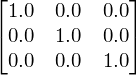

In [11]:
sympy.Matrix(mass_norm.round(2))

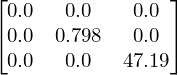

In [12]:
sympy.Matrix(stiffness_norm.round(3))

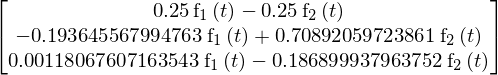

In [13]:
sympy.Matrix(force_norm)

The final form of the modal equations of motion are:

$$\left[\begin{matrix}1.0 & 0.0 & 0.0\\0.0 & 1.0 & 0.0\\0.0 & 0.0 & 1.0\end{matrix}\right]\begin{bmatrix}\ddot{x_1}\\\ddot{x_2}\\\ddot{\theta}\end{bmatrix}+ \left[\begin{matrix}0.0 & 0.0 & 0.0\\0.0 & 0.798 & 0.0\\0.0 & 0.0 & 47.19\end{matrix}\right]\begin{bmatrix}x_1\\x_2\\\theta\end{bmatrix}= \left[\begin{matrix}0.25 f_{1}{\left (t \right )} - 0.25 f_{2}{\left (t \right )}\\- 0.194 f_{1}{\left (t \right )} + 0.7089 f_{2}{\left (t \right )}\\0.0012 f_{1}{\left (t \right )} - 0.187 f_{2}{\left (t \right )}\end{matrix}\right]$$

Now we define a state variable, $w$, where:
$$w=\begin{bmatrix}x_1\\\dot{x_1}\\x_2\\\dot{x_2}\\\theta\\\dot{\theta}\end{bmatrix}$$
substituting:
$$\begin{matrix}\dot{w_1}=\dot{x_1}=w2\\
\dot{w_2}=\ddot{x_1}=0.25f_1-0.25f_2\\
\dot{w_3}=\dot{x_2}=w4\\
\dot{w_4}=\ddot{x_2}=-0.798x_2-0.19f_1+0.7089f_2\\
\dot{w_5}=\dot{\theta}=w6\\
\dot{w_6}=\ddot{\theta}=-47.19\theta+0.001f_1-0.187f_2\\
\end{matrix}$$

Now we can form the state space equations of the modal equations of motion. These have the form:
$$\dot{x}(t) = Ax(t) + Bu(t)$$
where:
$$A=blockdiag\begin{bmatrix}0 &1\\-\omega_i^2 & -2\zeta_i\omega_i\end{bmatrix}$$
and 
$$B=blockcol\begin{bmatrix}0 & 0 & ...&0 \\ g_0^i & g_1^i & ... & g_m^i\end{bmatrix}$$

Andso we can now form the Modal EOM in state space form:
$$
\begin{bmatrix}
0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & -0.798 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
0 & 0 & 0 & 0 & -47.19 & 0
\end{bmatrix}
\begin{bmatrix}x_1\\\dot{x_1}\\x_2\\\dot{x_2}\\\theta\\\dot{\theta}\end{bmatrix}+
\begin{bmatrix}
0 & 0\\
0.25 & -0.25\\
0 & 0\\
-0.19 & 0.709\\
0 & 0\\
0.001 & -0.187
\end{bmatrix}
\begin{bmatrix}
f_1\\f_2
\end{bmatrix}
$$

Define the forcing function for the two inputs

In [100]:
# define the forcing function
def force1(t):
    # set the maximum force output
    fmax = 100.0
    
    # return a bang-bang command
    return fmax * ((t > 0.25) - 2 * (t >= 1.25) + (t >= 2.25))

def force2(t):
    # set the maximum force output
    fmax = 3.0
    
    # return a bang-bang command
    return fmax * ((t > 0.25) - 2 * (t >= 1.25) + (t >= 2.25))

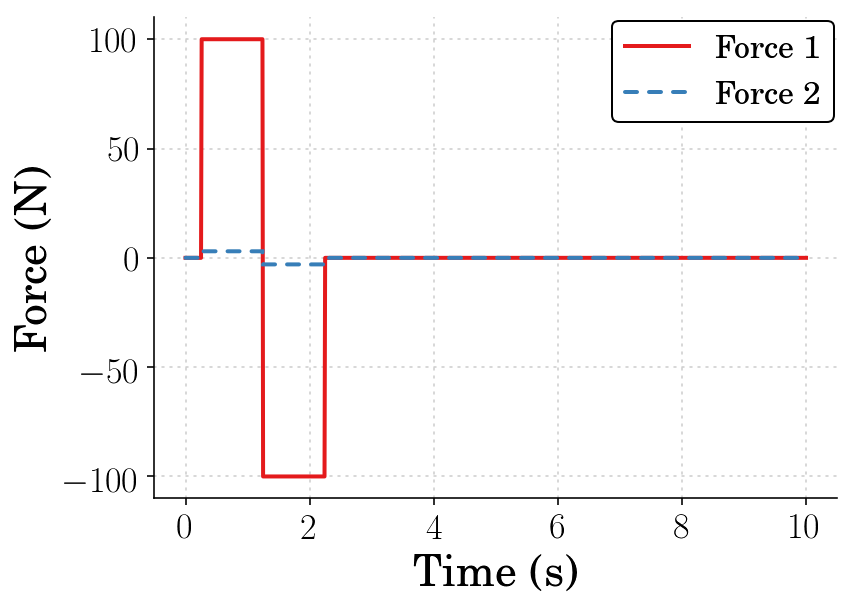

In [101]:
# Plot the force over 10 seconds
force_plot_time = np.linspace(0.0, 10.0, 1001)
plt.plot(force_plot_time, force1(force_plot_time),
         linewidth=2, linestyle='-', label=r'Force 1')
plt.plot(force_plot_time, force2(force_plot_time),
         linewidth=2, linestyle='--', label=r'Force 2')
# plt.plot(force_plot_time, shaping.shaped_input(force1, force_plot_time, Shaper1),
#          linewidth=2, linestyle='--', label=r'Force 3')
plt.ylabel('Force (N)')
plt.xlabel('Time (s)')
plt.legend()

In [205]:
# Define the states and state vector
w1, w2, w3, w4, w5, w6 = sympy.symbols('w1, w2, w3, w4, w5, w6', cls=sympy.Function)
w = [w1(t), w2(t), w3(t), w4(t), w5(t), w6(t)]

# Set up the state definitions and parameter substitution
sub_params = {x1 : w1(t),
              x2 : w2(t), 
              theta : w3(t),
              x1_dot : w4(t),
              x2_dot : w5(t), 
              theta_dot : w6(t), 
              m1 : 10.0,
              m2 : 5.0,
              m3 : 1.0,
              g : 9.81, 
              L : 0.25,
              k : 3,
#               f1: force1(t),
#               f2: force2(t)}
              f1: shaping.shaped_input(force1, t, Shaper2),
              f2: shaping.shaped_input(force2, t, Shaper1)}

# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w), 
                              lrhs.subs(sub_params), 
                              modules = mat2array)

In [206]:
# Set up the initial conditions for the solver
x1_init = 0.0
x1_dot_init = 0.0
x2_init = 0.0
x2_dot_init = 0.0
theta_init = 0.0 * np.pi/180
theta_dot_init = 0.0

# Pack the initial conditions into an array
x0 = [x1_init, x2_init, theta_init,  x1_dot_init, x1_dot_init, theta_dot_init]

# Create the time samples for the output of the ODE solver
sim_time = np.linspace(0.0, 10.0, 1001) # 0-10s with 1001 points in between

In [207]:
# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])
 
# define the sample time
dt = sim_time[1] - sim_time[0]   

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

In [208]:
# response_ZV = response
# response_ZV_same = response
# response_ZV_different = response
response_multi = response
# response_multi_reversed = response
# unshaped = response

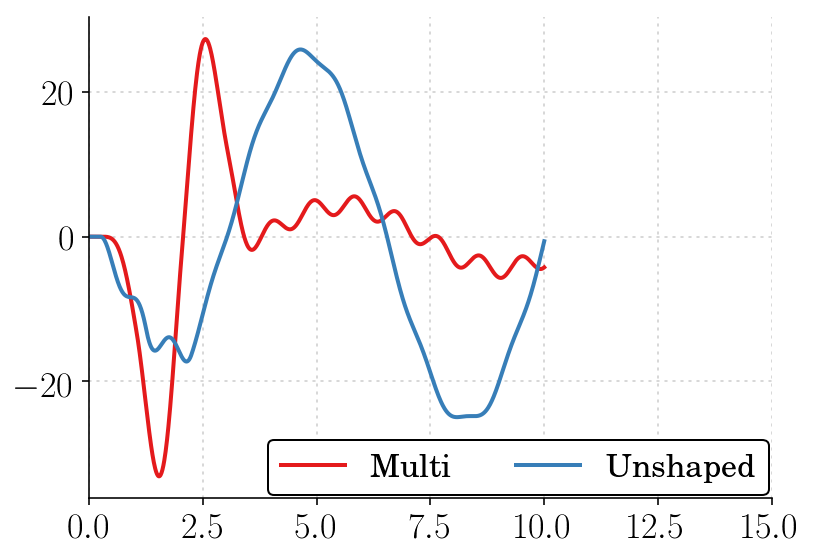

In [209]:
# plt.plot(sim_time, np.rad2deg(response_ZV_same[:, 2]),
#          linewidth=2, linestyle='-', label = r'Same ZV')
# plt.plot(sim_time, np.rad2deg(response_ZV_different[:, 2]),
#          linewidth=2, linestyle='-', label = r'Diff ZV')
# plt.plot(sim_time, np.rad2deg(response_ZV[:, 2]),
#          linewidth=2, linestyle='-', label = r'1 ZV')
# plt.plot(sim_time, response[:,0],
#          linewidth=2, linestyle='-', label = r'Multi')
plt.plot(sim_time, np.rad2deg(response_multi[:, 2]),
         linewidth=2, linestyle='-', label = r'Multi')
plt.plot(sim_time, np.rad2deg(unshaped[:, 2]),
         linewidth=2, linestyle='-', label = r'Unshaped')
plt.legend(ncol=2)
plt.xlim(0,15)

Now we will create the Multi-Input Shaper Impulses

In [191]:
# Manually fill in your eigenvalues and their conjugates
s_1 = np.complex(0.0, 0.89346264)
s_2 = np.complex(0.0, 6.86947775)
s_1_star = np.conjugate(s_1)
s_2_star = np.conjugate(s_2)
n = int(2)
m = int(2)
l = int(np.ceil((2*n) / (m + 1)))

# Manually fill in the G (B) matrix values
g_0_0 = 0.25
g_0_1 = -0.19
g_0_2 = 0.001

g_1_0 = -0.25
g_1_1 = 0.709
g_1_2 = -0.187

In [ ]:
a_full = np.array([0,0,0,0,0,0])
for i in range(10000):
    steps = np.linspace(0,1,10000)
    T = steps[i]
    P = np.array([[g_0_1, g_0_1*np.exp(-s_1*T), g_0_1*np.exp(-s_1*l*T),
             g_1_1, g_1_1*np.exp(-s_1*T), g_1_1*np.exp(-s_1*l*T)],
            [g_0_1, g_0_1*np.exp(-s_1_star*T), g_0_1*np.exp(-s_1_star*l*T),
             g_1_1, g_1_1*np.exp(-s_1_star*T), g_1_1*np.exp(-s_1_star*l*T)],
           [g_0_2, g_0_2*np.exp(-s_2*T), g_0_2*np.exp(-s_2*l*T),
             g_1_2, g_1_2*np.exp(-s_2*T), g_1_2*np.exp(-s_2*l*T)],
            [g_0_2, g_0_2*np.exp(-s_2_star*T), g_0_2*np.exp(-s_2_star*l*T),
             g_1_2, g_1_2*np.exp(-s_2_star*T), g_1_2*np.exp(-s_2_star*l*T)],
           [1,1,1,0,0,0],[0,0,0,1,1,1]])
    P_inv = np.linalg.pinv(P)
    w = np.array([[0],[0],[0],[0],[1],[1]])
    a = np.dot(P_inv,w)
    a_row = np.real(a.reshape(1,6))
    a_full = np.vstack((a_full, a_row))
a_full = np.delete(a_full,0,0)

In [218]:
index=np.array([0])
for i in range(6):
    index = np.vstack((index,np.argwhere(a_full[:,i][4:] > 0)[0][0]))
index = np.delete(index, (0), axis=0)
index_arg = np.argmax(index)
time2 = round(steps[4:][index[index_arg][0]],4)
time3 = round(time2 * 2,4)
impulse1_1 = round(a_full[:,0][4:][index[index_arg][0]],4)
impulse1_2 = round(a_full[:,1][4:][index[index_arg][0]],4)
impulse2_1 = round(a_full[:,2][4:][index[index_arg][0]],4)
impulse2_2 = round(a_full[:,3][4:][index[index_arg][0]],4)
impulse3_1 = round(a_full[:,4][4:][index[index_arg][0]],4)
impulse3_2 = round(a_full[:,5][4:][index[index_arg][0]],4)
df = pd.DataFrame({"Input 1":[impulse1_1,impulse1_2, impulse2_1], 
                   "Input 2":[impulse2_2,impulse3_1, impulse3_2],
                   "Times":[0,time2,time3]})
itable.PrettyTable(df)

Input 1,Input 2,Times
0.0089,1.5214,0.0
0.9821,-2.0428,0.7935
0.0089,1.5214,1.587


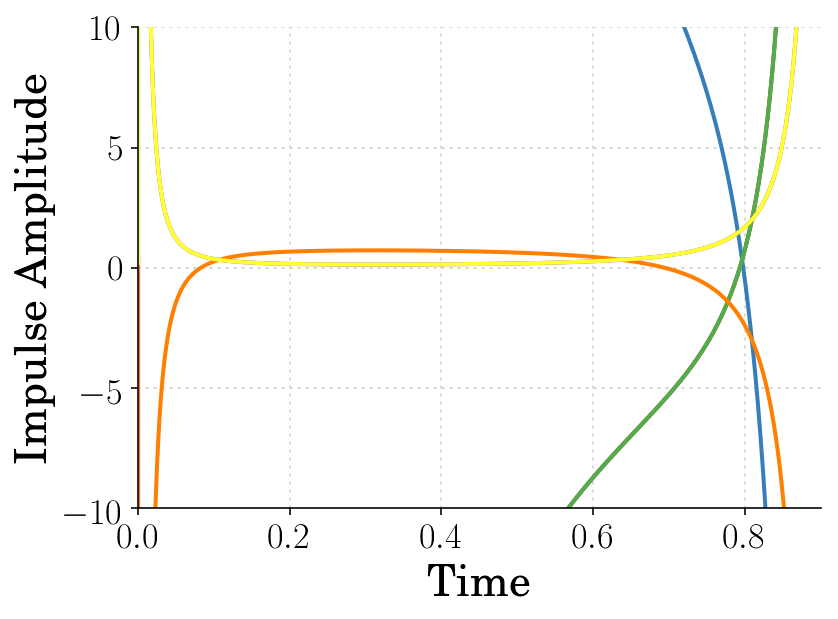

In [219]:
# Plot the impulses and find where all are positive
plt.plot(steps,a_full[:,0])
plt.plot(steps,a_full[:,1])
plt.plot(steps,a_full[:,2])
plt.plot(steps,a_full[:,3])
plt.plot(steps,a_full[:,4])
plt.plot(steps,a_full[:,5])
plt.ylim(-10,10)
plt.xlim(0.0,0.9);
plt.xlabel('Time')
plt.ylabel('Impulse Amplitude')

In [194]:
shaper_times = np.array([[ 0.0000],
       [ 0.7935],
       [ 1.587]])

shaper1_impulses = np.array([[ 0.0],
       [ 1.0],
       [0.0]])
Shaper1 = np.hstack((shaper_times, shaper1_impulses))

shaper2_impulses = np.array([[ 1.5194],
       [ -2.0388],
       [ 1.5194]])
Shaper2 = np.hstack((shaper_times, shaper2_impulses))

In [130]:
# example_shaper1 = shaping.ZV(0.25,0.017)
example_shaper1 = shaping.ZV(0.14,0)
example_shaper2 = shaping.ZV(1.09,0)
# example_shaper1 = shaping.ZV_2mode(Freqs[1],damp[1],Freqs[2],damp[2])
Shaperzv = example_shaper1.shaper
Shaperzv2 = example_shaper2.shaper

/Users/forrest/Documents/CRAWLAB-Student-Code/Forrest Montgomery/Multi_Input/InputShaping.py:1151: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dseq = np.zeros((round(seq[-1,0]/step)+2,1))
/Users/forrest/Documents/CRAWLAB-Student-Code/Forrest Montgomery/Multi_Input/InputShaping.py:1156: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dseq[index+1] = dseq[index+1] + woof*seq[nn,1]
/Users/forrest/Documents/CRAWLAB-Student-Code/Forrest Montgomery/Multi_Input/InputShaping.py:1157: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  dseq[index] = dseq[index]+seq[nn,1] - woof*seq[nn,1]


In [184]:
Shaperzv

array([[ 0.0000,  0.5000],
       [ 3.5714,  0.5000]])